In [31]:
require 'cutorch'
require 'cunn'
require 'nn';
require 'model';
require 'mnist_loader';
Plot = require 'itorch.Plot';

In [32]:
use_gpu = true

cutorch.setDevice(2)

if use_cuda then
  Tensor = torch.CudaTensor
else
  Tensor = torch.Tensor
end

G, D = get_model()
if use_gpu then
    G = G:cuda()
    D = D:cuda()
end

criterion = nn.ClassNLLCriterion()
if use_gpu then
    criterion = criterion:cuda()
end

In [33]:
train_set = mnist.loadTrainSet()

<mnist> done	


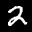

0	


In [42]:
displayData = train_set[1][1]
itorch.image(displayData)
print(train_set[1][2][9])

In [35]:
counter_tb = {}
D_fake_loss_tb = {}
D_real_loss_tb = {}
G_loss_tb = {}

In [36]:
fixed_noise = torch.randn(100)
if use_gpu then
    fixed_noise = fixed_noise:cuda()
end

In [37]:
counter = 0
batchsize = 1
epochsize = 1
learningrate = 1e-1

_, G_gradParameters = G:getParameters()
_, D_gradParameters = D:getParameters()

gradclip = 5

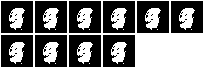

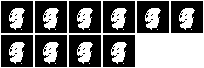

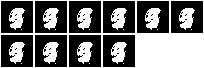

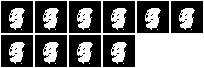

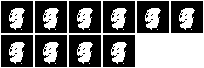

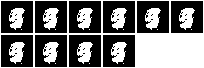

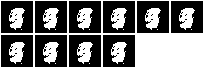

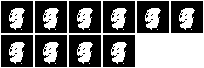

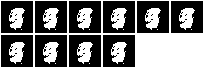

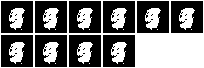

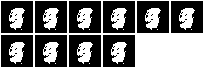

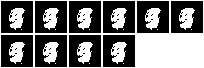

In [38]:
for epoch=1, epochsize do
train_set:shuffle()
for batch_count = 1, train_set:size() / batchsize do        
    for batch_count_idx = 1, batchsize do
        i = (batch_count - 1) * batchsize + batch_count_idx
        inputImgInput = train_set[i][1]:view(32, 32):cuda()
        inputVectorInput = train_set[i][2]:cuda()

        -- update D

        real_pred = D:forward({inputImgInput, inputVectorInput})
        real_target = 1
        local D_real_loss = criterion:forward(real_pred, real_target)

        D:zeroGradParameters()
        local t = criterion:backward(real_pred, real_target)
        D:backward({inputImgInput, inputVectorInput}, t)
        
        D_gradParameters:clamp(-gradclip, gradclip)
        D:updateParameters(learningrate)


        -- fake image        
        noise = torch.randn(100):cuda()
        fake_img = G:forward({noise, inputVectorInput})
        fake_pred = D:forward({fake_img, inputVectorInput})
        fake_target = 2
        local D_fake_loss = criterion:forward(fake_pred, fake_target)

        D:zeroGradParameters()

        local t = criterion:backward(fake_pred, fake_target)
        local fake_img_prime = D:backward({fake_img, inputVectorInput}, t)
            
        D_gradParameters:clamp(-gradclip, gradclip)
        D:updateParameters(learningrate)


        -- for generator
        G:zeroGradParameters()
        G:backward({noise, inputVectorInput}, fake_img_prime[1])

        -- add gradParameters
        G_gradParameters:clamp(-gradclip, gradclip)
        G:updateParameters(-1 * learningrate)

        new_fake_img = G:forward({noise, inputVectorInput})
        new_fake_pred = D:forward({new_fake_img, inputVectorInput})
        local G_loss = criterion:forward(new_fake_pred, fake_target)

        counter = counter + 1        
        if counter % 5000 == 0 then
            table.insert(counter_tb, counter)
            table.insert(D_fake_loss_tb, D_fake_loss)
            table.insert(D_real_loss_tb, D_real_loss)
            table.insert(G_loss_tb, G_loss)
                
            res = torch.zeros(10, 32, 32)
            labelVector = torch.zeros(10)
            if use_gpu then
                res = res:cuda()
                labelVector = labelVector:cuda()
            end
            for m=1, 10 do  
                noise = torch.randn(100):cuda()
                labelVector:zero()
                labelVector[m] = 1
                local genImg = G:forward({noise, labelVector}) + 0.5
                res[{m, {}, {}}] = genImg
            end
            itorch.image(res)
        end
    end
end
end

In [39]:
print(#counter_tb)
print(#D_fake_loss_tb)

In [40]:
plot = Plot():line(counter_tb, D_fake_loss_tb, "red", "D fake loss")
plot:line(counter_tb, D_real_loss_tb, "pink", "D real loss")
plot:line(counter_tb, G_loss_tb, "blue", "G loss")
plot:draw()
plot:save("gan_traning_loss_plot.html")